1️⃣ 전체 플로우

1. 텍스트 추출 (OCR)
- **PaddleOCR** 사용 → 설계도에서 모든 텍스트 + 좌표 추출

2. 도형/선 탐지 (VFM)
- Hough Transform + OpenCV :: 구림 -> dectection_v1
- YOLOv8 이런 모델로 테스트 :: 추가학습이 필요함
- SAM 테스트 ::: mask만 제공 → 클래스별 구분, 점선/실선 식별은 후처리 필요(정보)

3. 텍스트-도형 매핑
- OCR 좌표와 도형 좌표 비교 → 도형 안에 포함되는 텍스트 연결
- 텍스트 중심점이 도형 bbox 안에 들어가면 매핑



/tmp/ipykernel_769425/3902340902.py:29: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_test = PaddleOCR(use_angle_cls=True, lang='korean')
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory 

Loading Zigeng/SlimSAM-uniform-77 model...


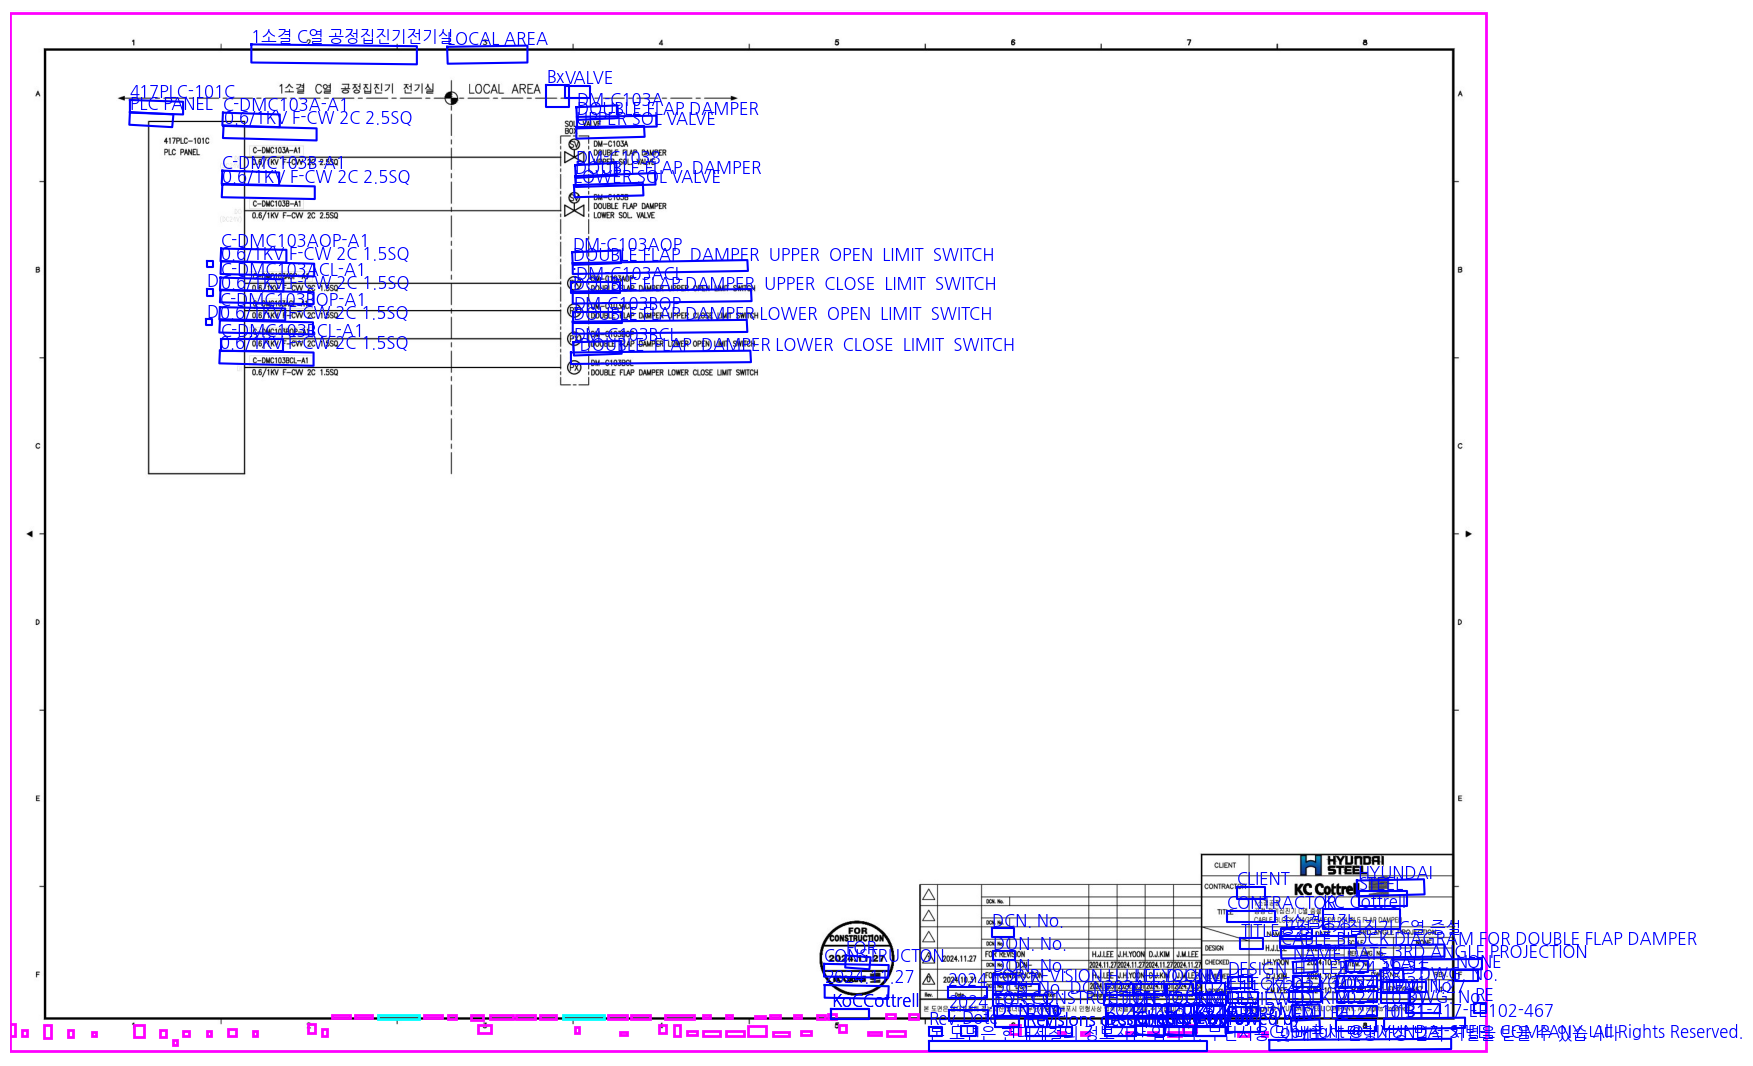

In [2]:
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import SamModel, SamProcessor
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
# 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.patches as patches

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)

# -------------------------------
# 0. 이미지 로드
# -------------------------------
image_path = "./data/test05.JPG"
image_cv = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# 원본 이미지 크기
orig_H, orig_W = image_cv.shape[:2]

# -------------------------------
# 1. OCR
# -------------------------------
ocr_test = PaddleOCR(use_angle_cls=True, lang='korean')  
result = ocr_test.ocr(image_path)

# result[0]['rec_texts']      # 인식된 텍스트 리스트
# result[0]['rec_scores']     # 각 텍스트 신뢰도
# result[0]['rec_polys']      # 각 텍스트 영역 좌표
# result[0]['textline_orientation_angles']  # 라인 회전 정보

# -------------------------------
# 2. VLM
# -------------------------------
### 테스트할 이미지 부르기
image = Image.open(image_path).convert("RGB")

### 모델 부르기
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32

model_id = "Zigeng/SlimSAM-uniform-77"
print(f"Loading {model_id} model...")
model = SamModel.from_pretrained(
    model_id,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = SamProcessor.from_pretrained(model_id)

### SAM 입력 생성
W, H = image_pil.size
# 전체 이미지를 box prompt로 지정
box = torch.tensor([[[0, 0, W, H]]], dtype=torch.float).to(device)
inputs = processor(image_pil, boxes=box, return_tensors="pt").to(device)

# -------------------------------
# 3. SAM Forward + Mask 후처리
# -------------------------------
with torch.no_grad():
    outputs = model(**inputs)

# post_process_masks → 원본 이미지 크기로 변환
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

# -------------------------------
# 4. Mask 후처리: 블록/선 구분
# -------------------------------
processed_objects = []

for mask in masks:
    # list 안 tensor → numpy
    mask_np = mask.cpu().numpy()  # shape: [1,3,H,W]
    mask_np = np.squeeze(mask_np) # shape: [3,H,W]

    # num_masks 차원 반복
    if mask_np.ndim == 3:
        for i in range(mask_np.shape[0]):
            single_mask = mask_np[i]  # shape: [H,W]
            mask_binary = (single_mask > 0).astype(np.uint8) * 255

            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
            mask_clean = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel)
            mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

            contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for c in contours:
                x, y, w, h = cv2.boundingRect(c)
                if w*h < 50:
                    continue
                aspect_ratio = w / h
                obj_type = "line" if aspect_ratio > 5 or aspect_ratio < 0.2 else "block"
                processed_objects.append({
                    "bbox": (x, y, w, h),
                    "mask": c,
                    "type": obj_type,
                    "texts": []
                })
# -------------------------------
# 5. OCR 텍스트 매핑
# -------------------------------
for obj in processed_objects:
    x1, y1, w, h = obj["bbox"]
    x2, y2 = x1 + w, y1 + h
    for idx, poly in enumerate(result[0]['rec_polys']):
        poly = np.array(poly)  # shape: (4,2)
        px_min, py_min = poly.min(axis=0)
        px_max, py_max = poly.max(axis=0)
        # 겹침 여부 확인 (AABB 간단 비교)
        if not (px_max < x1 or px_min > x2 or py_max < y1 or py_min > y2):
            obj["texts"].append({
                "text": result[0]['rec_texts'][idx],
                "score": result[0]['rec_scores'][idx],
                "poly": poly.tolist(),
                "angle": result[0]['textline_orientation_angles'][idx]
            })
# -------------------------------
# 6. 시각화 (텍스트 유지, 블록/라인)
# -------------------------------
plt.figure(figsize=(20,20))
plt.axis('off')
ax = plt.gca()
ax.imshow(image_rgb)

for obj in processed_objects:
    x, y, w, h = obj["bbox"]
    area = w*h
    aspect_ratio = w/h
    if area < 50:
        continue
    obj_type = "line" if aspect_ratio > 8 or aspect_ratio < 0.125 else "block"
    rect_color = 'cyan' if obj_type=="line" else 'magenta'
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=rect_color, facecolor='none'))

    # 텍스트
    for t in obj["texts"]:
        poly = np.array(t["poly"])
        poly_closed = np.vstack([poly, poly[0]])
        ax.plot(poly_closed[:,0], poly_closed[:,1], color='blue')
        ax.text(poly[0][0], poly[0][1]-5, t["text"], fontsize=12, color='blue', fontproperties=font_prop)

plt.show()

In [3]:
result[0]['rec_texts']

['1소결 C열 공정집진기전기실',
 'LOCAL AREA',
 'Bx',
 'VALVE',
 '417PLC-101C',
 'PLC PANEL',
 'C-DMC103A-A1',
 'DM-C103A',
 'DOUBLE FLAP DAMPER',
 '0.6/1KV F-CW 2C 2.5SQ',
 'UPPER SOL VALVE',
 'C-DMC103B-A1',
 'DM-C1038',
 'DOUBLE FLAP  DAMPER',
 '0.6/1KV F-CW 2C 2.5SQ',
 'LOWER SOL VALVE',
 'C-DMC103AOP-A1',
 'DM-C103AOP',
 '',
 '0.6/1KV F-CW 2C 1.5SQ',
 'DOUBLE FLAP  DAMPER  UPPER  OPEN  LIMIT  SWITCH',
 'C-DMC103ACL-A1',
 ':DM-C103ACL',
 'D',
 '0.6/1KV F-CW 2C 1.5SQ',
 'DOUBLE FLAP DAMPER  UPPER  CLOSE  LIMIT  SWITCH',
 'C-DMC103BOP-A1',
 'DM-C103BOP',
 'D',
 '0.6/1KV F-CW 2C 1.5SQ',
 'DOUBLE FLAP DAMPER LOWER  OPEN  LIMIT  SWITCH',
 'C-DMC103BCL-A1',
 'DM-C103BCL',
 '0.6/1KV F-CW 2C 1.5SQ',
 'i DOUBLE  FLAP  DAMPER LOWER  CLOSE  LIMIT  SWITCH',
 'HYUNDAI',
 'CLIENT',
 'STEEL',
 'CONTRACTOR',
 'KC Cottrell',
 'DCN. No.',
 '1소결공장',
 'TITLE',
 '공정 전기집진기 C열 증설',
 'DON. No.',
 'CABLE BLOCK DIAGRAM FOR DOUBLE FLAP DAMPER',
 'FOR',
 'CONSTRUCTON',
 'NAME',
 'DATE',
 '3RD ANGLE PROJECTION',
 'DON. No